In [17]:
!pip install plotly
!pip install networkx
!pip install geopy
!pip install fuzzywuzzy

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [22]:
# import os
# import warnings

# import numpy as np

import pickle
import pandas as pd
pd.set_option("display.max_rows",40)
# pd.set_option("display.max_columns", 10)
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from utils import *
from algo import *

import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import norm
import numpy as np

mapbox_access_token = 'pk.eyJ1IjoibWljaGFlbHJvdXN0IiwiYSI6ImNsM2tpbXlxdTA2dnUzY3AzdnZndWF2MGIifQ.eAlbvCcax9TMLeOyel2PdA'

import importlib
importlib.reload(utils)
importlib.reload(algo)
%load_ext autoreload
%autoreload 2

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [20]:
END_TIME = Time(h=10, m=10).in_seconds()
END_ID = ZURICH_HB_ID
START_ID = ZURICH_HEURIED_ID
HB = 8503000
FLUGHAFEN = 8503016
OPFIKON = 8503340
OERLIKON = 850300
OPERNHAUS = 8576195
ZOLLIKON = 8503100

In [21]:
#start color 2, end color 1

df_stops['color'] = 0
df_stops.loc[END_ID,'color'] = 1
df_stops.loc[START_ID,'color'] = 2


df_stops['color'] = df_stops['color'].astype(str)


NameError: name 'df_stops' is not defined

In [ ]:
results = generate_routes_yen(8503100, FLUGHAFEN, END_TIME, day_of_week=1, min_confidence=0.1, nroutes=5, max_iter=10, verbose=True)

### Clean DataFrame

In [77]:
from datetime import datetime

def print_directions(result_from_algo, end_stop_name):
    
    result = result_from_algo.copy()

    rows = []
    for row in range(len(result)):
        
        # check if last trip id was the same
        if row != 0:
            if result.iloc[row]['trip_id'] == result.iloc[row - 1]['trip_id']:
                continue
                
        walking_route = result.iloc[row]['trip_id'] == 'walk'
        
        if not walking_route:
            
            next_row = row + 1
            same_trip_id = True
            while same_trip_id:
                try:
                    same_trip_id = result.iloc[next_row]['trip_id'] == result.iloc[row]['trip_id']
                except IndexError:
                    same_trip_id = False
                    
                if same_trip_id:
                    result.iloc[row]['arr_stop_name'] = result.iloc[next_row]['arr_stop_name']
                    result.iloc[row]['arr_time_s'] = result.iloc[next_row]['arr_time_s']
                    next_row += 1
                else:
                    break

        dep_sec = Time.from_seconds(result.iloc[row]['dep_time_s']) if not walking_route else ''
        arr_sec = Time.from_seconds(result.iloc[row]['arr_time_s']) if not walking_route else ''
        
        if not walking_route:
            dep_sec = datetime(2019, 1, 1, int(dep_sec.h), int(dep_sec.m), int(dep_sec.s)).strftime('%H:%M')
            arr_sec = datetime(2019, 1, 1, int(arr_sec.h), int(arr_sec.m), int(arr_sec.s)).strftime('%H:%M')

        else:
            result.iloc[row]['dep_stop_name'] = ""
            result.iloc[row]['arr_stop_name'] = ""
            result.iloc[row]['transport_name'] = "walk"
            try:
                result.iloc[row]['trip_headsign'] = result.iloc[row + 1]['dep_stop_name']
            except IndexError:
                result.iloc[row]['trip_headsign'] = end_stop_name
            result.iloc[row]['route_short_name'] = ""
        
        result.iloc[row]['transport_name'] = "Train" if result.iloc[row]['transport_name'] == 'zug' else result.iloc[row]['transport_name'].capitalize()
        result.iloc[row]['transport_name'] = f"{result.iloc[row]['transport_name']} {result.iloc[row]['route_short_name']} towards {result.iloc[row]['trip_headsign']}"

        rows += [[
            result.iloc[row]['transport_name'],
            result.iloc[row]['dep_stop_name'],
            dep_sec,
            result.iloc[row]['arr_stop_name'],
            arr_sec
        ]]
    pretty_output = pd.DataFrame(rows, columns=['Route', 'From', 'Departing at', 'To', 'Arriving at', ]).reset_index().rename({'index': 'Connection #'}, axis=1)
    pretty_output['Connection #'] += 1
    return pretty_output

print_directions(results[4][0], 'Zürich Flughafen')

,Connection #,Route,From,Departing at,To,Arriving at
0,1,Walk towards Zürich Stadelhofen,,,,
1,2,Train 3 towards Wetzikon,Zürich Stadelhofen,09:37,Effretikon,09:50
2,3,Train 24 towards Zug,Effretikon,09:53,Zürich Flughafen,10:02


In [ ]:
def preprocess(df = path_conn_datas):
    final_df_dep = df.merge(df_stops, left_on ='dep_stop_id', right_on=df_stops.index)
    final_df_dep.rename(columns = {'stop_name':'dep_name'}, inplace=True)
    final_df_arr = final_df_dep.merge(df_stops,left_on='arr_stop_id', right_on='stop_id')
    final_df_arr.rename(columns = {'stop_name':'arr_name'}, inplace=True)
    d = final_df_arr.drop(columns=['mean','std','dep_stop_id', 'latitude_x','longitude_x', 'color_x' , 'latitude_y','longitude_y', 'color_y'])
    d['trip_time'] = np.where(d['trip_id'] == 'walk', d['weight'], np.abs(d['dep_time_s']-d['arr_time_s']))
    d['dep_time_s']= d['dep_time_s'].apply(lambda x : Time.from_seconds(x))
    d['arr_time_s']= d['arr_time_s'].apply(lambda x : Time.from_seconds(x))
    d['dep_time_s'] = np.where(d['trip_id'] == 'walk', '-', d['dep_time_s'])
    d['arr_time_s'] = np.where(d['trip_id'] == 'walk', '-', d['arr_time_s'])
    d['proba'] = d['proba'].astype(float)
    return d

In [22]:
#helper function
def get_lat_long(id):
    return (df_stops.loc[id].latitude, df_stops.loc[id].longitude)

### Itinerary draw for Fastest Path Connection


In [36]:

def f(df):
    fig = px.scatter_mapbox(df_stops, hover_name="stop_name", lat="latitude", lon="longitude", color='color', zoom=13, opacity = 1)
    lats = []
    lons = []
    for _, row in df.iterrows():
        loc_dep = get_lat_long(row['dep_stop_id'])
        loc_arr = get_lat_long(row['arr_stop_id'])

        lats.append(loc_dep[0])
        lats.append(loc_arr[0])
        lons.append(loc_dep[1])
        lons.append(loc_arr[1])

    fig.add_trace(go.Scattermapbox(
        mode = "lines",
        lon = lons,
        lat = lats,
        hoverinfo='none'
    ))
    fig.update_layout(
    mapbox = {
    'style': "open-street-map"},
    showlegend = False
    ) 

    fig.show()



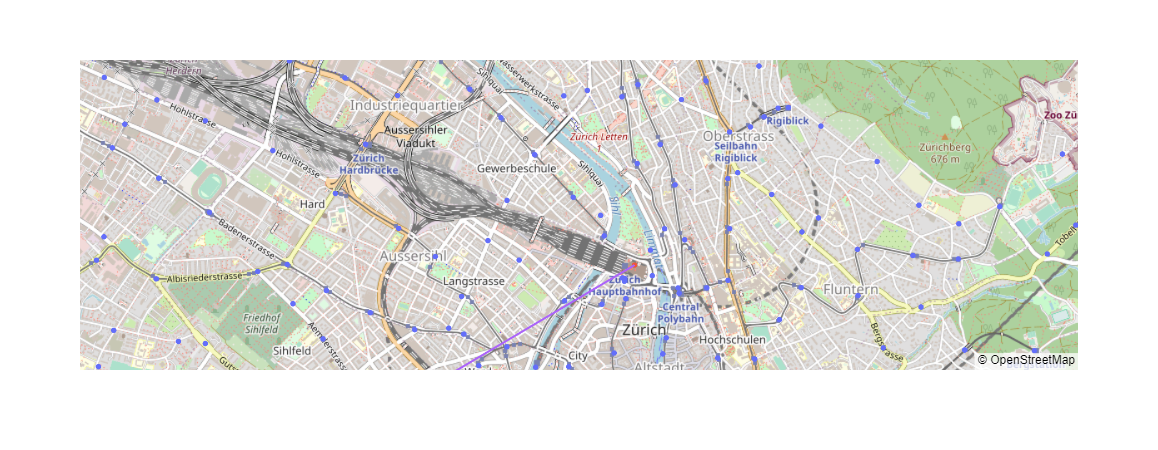

In [37]:
f(path_conn_datas)

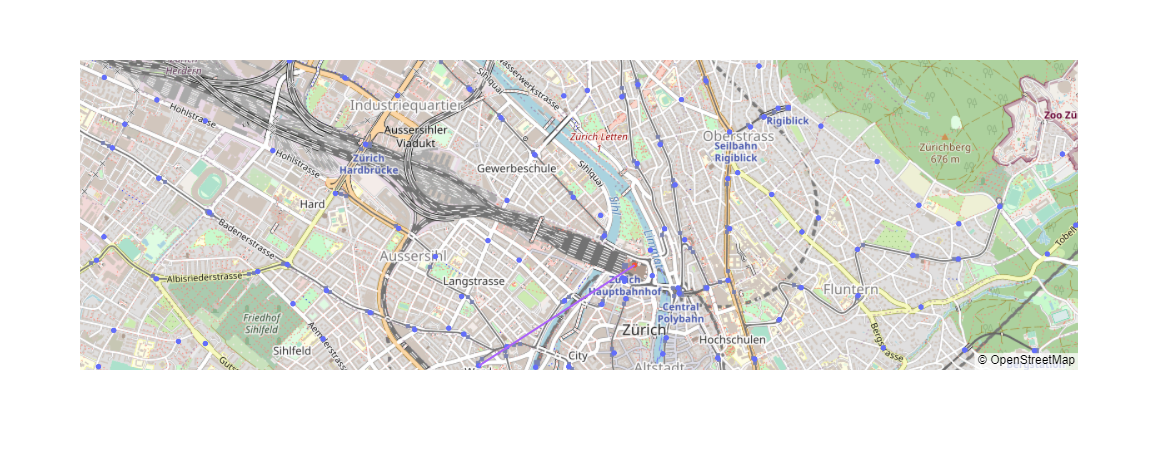

In [8]:

# Make map
lats=[47.378176, 47.372324]
lons=[8.540212, 8.526845]

fig = px.scatter_mapbox(df_stops, hover_name="stop_name", lat="latitude", lon="longitude", color='color', zoom=13)


# Add path trace
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = lons,
    lat = lats,
    hoverinfo='none'
))


fig.update_layout(
    mapbox = {
        'style': "open-street-map"},
    showlegend = False
    ) 

fig.show()

## More complex visualizations

In [ ]:
# make map of 15k radius around Zurich

lats=[47.378176, 47.372324]
lons=[8.540212, 8.526845]

# fig = px.scatter_mapbox(df_stops, hover_name="stop_name", lat="latitude", lon="longitude",color='color', zoom=13)
# fig = px.line_geo(, )

# fig.add_trace()
fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = lons,
    lat = lats,
    hoverinfo='none'
))

# go.Scattermapbox()

# fig.add_trace(go.Scattermapbox(
#     lat=df_stops['latitude'],
#     lon=df_stops['longitude'],
#     mode='markers',
#     marker=go.scattermapbox.Marker(
#         size=10,
#         color='rgb(255, 0, 0)',
#         opacity=0.7
#     ),
#     text=df_stops['stop_name'],
#     # hoverinfo='text'
# ))

# fig.update_layout(mapbox_style="open-street-map", zoom=13)

fig.update_layout(
    mapbox = {
        'accesstoken': mapbox_access_token,
        'style': "open-street-map", 'zoom': 13,
        'center': {'lat':47.378176, 'lon':8.540212}
        },
    showlegend = True)


# fig.update_layout(
#     mapbox = {
#         'accesstoken': token,
#         'style': "streets"},
#     showlegend = False)

# token = open(".mapbox_token").read() # you need your own token

# fig = go.Figure(go.Scattermapbox(
#     mode = "markers+text+lines",
#     lon = [-75, -80, -50], lat = [45, 20, -20],
#     marker = {'size': 20, 'symbol': ["bus", "harbor", "airport"]},
#     text = ["Bus", "Harbor", "airport"],textposition = "bottom right"))

# fig.update_layout(
#     mapbox = {
#         'accesstoken': token,
#         'style': "outdoors", 'zoom': 0.7},
#     showlegend = False)

fig.show()

In [ ]:


fig = px.scatter_mapbox(df_stops, hover_name="stop_name", lat="latitude", lon="longitude",color='color', zoom=13)
# fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox = {
        'accesstoken': token,
        'style': "streets"},
    showlegend = False)

In [ ]:
# token = open(".mapbox_token").read() # you need your own token


fig = go.Figure(go.Scattermapbox(
    mode = "markers+text+lines",
    lon = [-75, -80, -50], lat = [45, 20, -20],
    marker = {'size': 20, 'symbol': ["bus", "harbor", "airport"]},
    text = ["Bus", "Harbor", "airport"],textposition = "bottom right"))

fig.update_layout(
    mapbox = {
        'accesstoken': token,
        'style': "streets", 'zoom': 0.7},
    showlegend = False)

fig.show()